# Pixel DataLoader in `neuralhydrology`

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [12]:
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_173310")
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_200242")
run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [31]:
cfg.dataset

'pixel'

In [13]:
ds = xr.open_dataset(cfg.dynamic_nc_file)

In [14]:
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

100%|██████████| 669/669 [00:00<00:00, 2152.81it/s]


# Load model

In [15]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

Using the model weights from /datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# Get training/test dataset

In [16]:
# with open(cfg.run_dir / "train_data/train_data_scaler.p", "rb") as fp:
#     scaler = pickle.load(fp)

# # train_ds = PixelDataset(cfg, is_train=False, period="train", scaler=scaler)
# # test_ds = PixelDataset(cfg, is_train=False, period="test", scaler=scaler)

# Check the Performance of model

### clip predictions to zero!

In [17]:
preds["discharge_spec_sim"] = preds["discharge_spec_sim"].clip(min=0)

# Check the Performance of model

In [18]:
if "errors" not in globals():
    errors = calculate_all_error_metrics(preds, basin_coord="station_id")
else:
    print("Already run errors!")

Already run errors!


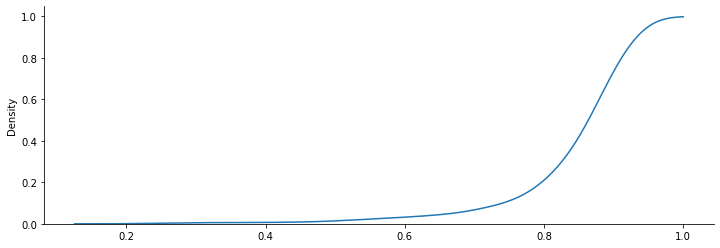

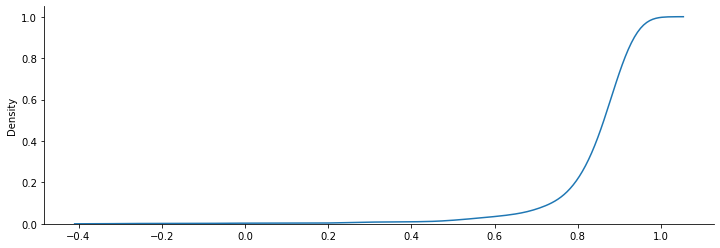

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

da = errors["NSE"].where(errors["NSE"] > 0)
f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(da.values[np.isfinite(da)], cumulative=True, clip=(0, 1))
sns.despine()

f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(errors["NSE"].values[np.isfinite(errors["NSE"])], cumulative=True)
sns.despine()

In [20]:
def print_summaries(errors: xr.Dataset):
    print(f"Median NSE: \t{float((errors['NSE']).median().values):.2f}")
    print(f"Mean NSE: \t{float((errors['NSE']).mean().values):.2f}")
    print(f"Min NSE: \t{float((errors['NSE']).min().values):.2f}")
    print(f"Max NSE: \t{float((errors['NSE']).max().values):.2f}")
    print(f"P(Errors < 0): \t{(errors['NSE'] < 0).mean().values:.2f}")
    print("\n")

print_summaries(errors)
print_summaries(errors.where(errors["NSE"] > 0))

Median NSE: 	0.87
Mean NSE: 	0.84
Min NSE: 	-0.32
Max NSE: 	0.96
P(Errors < 0): 	0.00


Median NSE: 	0.87
Mean NSE: 	0.84
Min NSE: 	0.20
Max NSE: 	0.96
P(Errors < 0): 	0.00




# Visualise Hydrographs

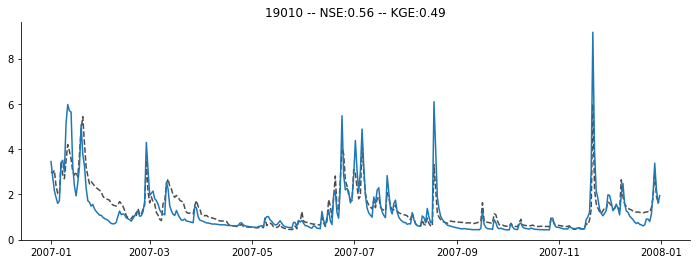

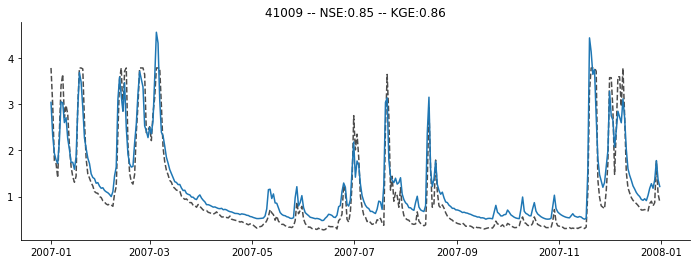

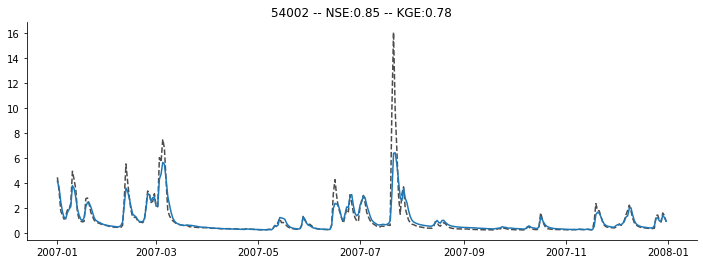

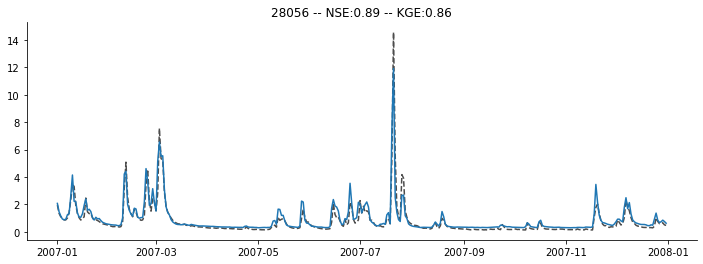

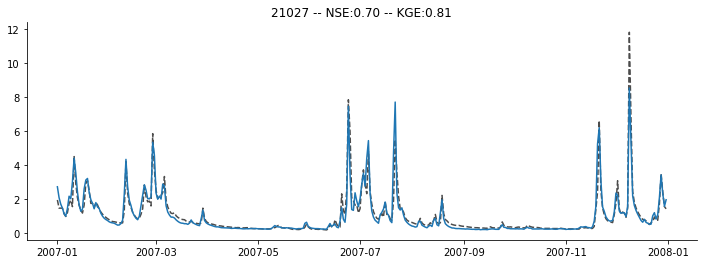

In [22]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.station_id.values)
    p = preds.sel(date="2007", station_id=pixel)
    ax.plot(p.date, p["discharge_spec_obs"], label="obs", color="k", ls="--", alpha=0.7)
    ax.plot(p.date, p["discharge_spec_sim"], label="sim")
    
    ax.set_title(f"{pixel} -- NSE:{errors.sel(station_id=pixel).NSE.values:.2f} -- KGE:{errors.sel(station_id=pixel).KGE.values:.2f}")
    sns.despine()

# forcing the model with Climate Scenarios

In [24]:
from copy import deepcopy

f_cfg = deepcopy(cfg)
f_cfg._cfg["dynamic_nc_file"] = f_cfg._cfg["dynamic_nc_file"].parent / "ALTERED_dynamic_ds.nc"

In [25]:
altered_ds = xr.open_dataset(cfg.dynamic_nc_file)
if f_cfg.dynamic_nc_file.exists():
    # delete the file if already exists so we can overwrite it
    f_cfg.dynamic_nc_file.unlink()

In [26]:
# precipitation made 30% higher
altered_ds["precipitation"] = altered_ds.precipitation * 1.3

# NO freezing temperatures and warming
altered_ds["temperature"] = (
    altered_ds["temperature"]
    # update positive temperatures to be 30% higher
    .where(altered_ds.temperature < 0, altered_ds.temperature * 1.3)
    # update negative temperatures to be 1degC (no zero-degree days)
    .where(altered_ds.temperature > 0, 1)
)

<ipython-input-27-57fd43d0718a>:11: RuntimeWarning: divide by zero encountered in log
  ax.hist(flat_finite(np.log(flat_finite(altered_ds.precipitation.values))), label="Precip +30%", bins=100, alpha=0.6)
<ipython-input-27-57fd43d0718a>:12: RuntimeWarning: divide by zero encountered in log
  ax.hist(flat_finite(np.log(flat_finite(ds.precipitation.values))), label="Control Precip", bins=100, alpha=0.6)


Text(0.5, 1.0, 'Log Precip')

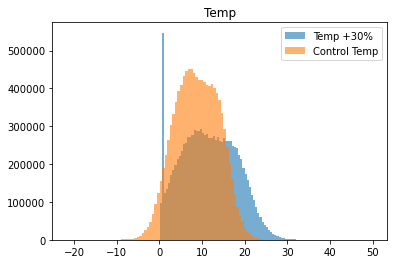

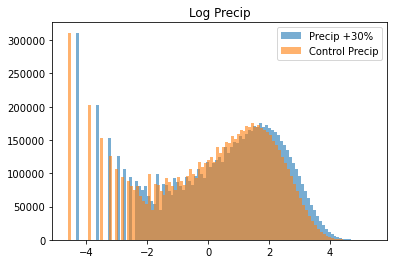

In [27]:
def flat_finite(arr):
    return arr[np.isfinite(arr)]

f, ax = plt.subplots()
ax.hist(flat_finite(altered_ds.temperature.values), label="Temp +30%", bins=100, alpha=0.6)
ax.hist(flat_finite(ds.temperature.values), label="Control Temp", bins=100, alpha=0.6)
plt.legend()
ax.set_title("Temp")

f, ax = plt.subplots()
ax.hist(flat_finite(np.log(flat_finite(altered_ds.precipitation.values))), label="Precip +30%", bins=100, alpha=0.6)
ax.hist(flat_finite(np.log(flat_finite(ds.precipitation.values))), label="Control Precip", bins=100, alpha=0.6)
plt.legend()
ax.set_title("Log Precip")

In [28]:
input("Do you want to continue?")
altered_ds.to_netcdf(f_cfg.dynamic_nc_file)

Do you want to continue? 


### run forward pass with the altered dataset

In [29]:
from neuralhydrology.evaluation import get_tester
from scripts.read_nh_results import _load_dict_to_xarray

tester = get_tester(cfg=f_cfg, run_dir=f_cfg.run_dir, period="test", init_model=True)
results = tester.evaluate(epoch=None, save_results=False, metrics=f_cfg.metrics)
forced_pred = _load_dict_to_xarray(results)

# Evaluation: 100%|██████████| 669/669 [11:16<00:00,  1.01s/it]

 33%|███▎      | 219/669 [00:00<00:00, 2186.92it/s]

100%|██████████| 669/669 [00:00<00:00, 2171.18it/s]


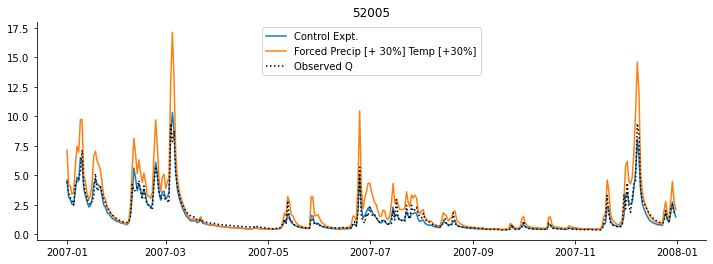

In [30]:
station = np.random.choice(preds.station_id.values)

f, ax = plt.subplots(figsize=(12, 4))
obs = preds["discharge_spec_obs"].sel(station_id=station, date="2007")
orig = preds["discharge_spec_sim"].sel(station_id=station, date="2007")
# forc = forced_pred_rainfall["discharge_spec_sim"].sel(station_id=station, date="2007")
forc_both = forced_pred["discharge_spec_sim"].sel(station_id=station, date="2007")

ax.plot(orig.date.values, orig.values, label="Control Expt.")
# ax.plot(forc.date.values, forc.values, label="Forced Precip [+ 30%]")
ax.plot(forc_both.date.values, forc_both.values, label="Forced Precip [+ 30%] Temp [+30%]")
ax.plot(obs.date.values, obs.values, label="Observed Q", color="k", ls=":")
ax.set_title(str(station))
sns.despine()
plt.legend()